# **Predicting Restaurant Closures During COVID**

**Authors:** Eugene Chong and Tyler Bradford

CIS 545

**NOTE:** In case any of the plotly plots in the visualization section have not properly rendered in the upload `.ipynb` notebook, you can view them in the Colab notebook here: https://colab.research.google.com/drive/1oBxhm6lnicPvAIoyvcZv6SXJvV3aqA60?usp=sharing


COVID has brought tremendous strain on the US economy with a particular emphasis on the restaurant industry given the risks of in person dining. In this project we will use [SafeGraph's](https://www.safegraph.com/) POI and Movement data to explore the relationship between human movement data (derived from cell phone tracking location information) and the open/closed status of restaurants across the US.
 

# Imports and Installs

In [ ]:
pip install boto3

     |████████████████████████████████| 133kB 13.4MB/s 
     |████████████████████████████████| 7.1MB 8.3MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 143kB 62.5MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import boto3
import gzip
import os
import pandas as pd
import numpy as np

# Create Filtered Movement Datasets

SafeGraph's POI coverage includes over 6 million locations in the US, and its movement data captures the cell location of hundreds of thousands of devices each week. Because we only needed to look at restaurants in this analysis, we developed a data pipeline that pulls down the raw weekly SG data, filters it to just the restaurants (~10% of the total POIs), and cuts out columns that we already have in the POI data (e.g., city/state information about each POI). This appraoch helps us conserve memory as well as optimize performance later on in our analysis.

Because our AWS Educate accounts don't allow us to create an Access Key and Secret Access Key, we had to write the data to disk and then upload to s3 using the GUI.

In [ ]:
# read the POI data for filtering
!wget https://safegraph-cis545.s3.amazonaws.com/core_poi.csv.gz -P /content 
poi_data = pd.read_csv('core_poi.csv.gz', compression='gzip',
                   error_bad_lines=False)

--2020-12-16 01:13:30--  https://safegraph-cis545.s3.amazonaws.com/core_poi.csv.gz
Resolving safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)... 52.217.74.172
Connecting to safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)|52.217.74.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74968182 (71M) [application/x-gzip]
Saving to: ‘/content/core_poi.csv.gz’

core_poi.csv.gz     100%[===================>]  71.50M  27.8MB/s    in 2.6s    

2020-12-16 01:13:33 (27.8 MB/s) - ‘/content/core_poi.csv.gz’ saved [74968182/74968182]



#### s3 Connection Setup

In [ ]:
s3 = boto3.client(
    service_name='s3',
    endpoint_url = 'https://s3.wasabisys.com',
    region_name='us-east-1',
    aws_access_key_id='EE7VEPDUDVZ3P297ATBF',
    aws_secret_access_key='SuHukXGdZXJU1ZE4QPJgj9zXbCFBNwdqeudbwnnJ'
)

In [ ]:
# Reduce the columns to only these for optimization
output_cols = ['safegraph_place_id', 'location_name',
       'brands', 'date_range_start', 'date_range_end', 'raw_visit_counts',
       'raw_visitor_counts', 'visits_by_day', 'poi_cbg',
       'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'distance_from_home', 'median_dwell',
       'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_week_brand', 'device_type']

#### Create Restaurant Movement Datasets

Note: this full data pull/write take over an hour to complete in full and is shown here not to be run but for data pipeline transparency.

In [ ]:
%%time
# There are two filepath formats in the s3 bucket. This is the newer one
# The newer filepath format. Only take June
all_objects = s3.list_objects_v2(Bucket = 'sg-c19-response', Prefix='weekly-patterns-delivery/weekly/patterns/2020/')
new_files = []
for f in all_objects['Contents']:
  name = f['Key']
  year = int(name.split('/')[3])
  month = int(name.split('/')[4])
  if "SUCCESS" not in f['Key'] and month <= 6:
    new_files.append(name)

# Write filtered files to disk
for file in new_files:
  year = int(file.split('/')[3])
  month = int(file.split('/')[4])
  day = int(file.split('/')[5])
  obj = s3.get_object(Bucket='sg-c19-response', Key=file)
  print(f'reading {file}')
  gz = gzip.GzipFile(fileobj=obj['Body'])
  patterns_df = pd.read_csv(gz)
  patterns_df = patterns_df[output_cols]
  patterns_df = patterns_df[patterns_df.safegraph_place_id.isin(poi_data.safegraph_place_id)] #filter to just restaurants
  output_path = f'monthly_patterns_{year}_{month}.csv.gz'
  print(f'writing {year}-{month}-{day} patterns to disk')
  patterns_df.to_csv(output_path, mode='a', header=not os.path.exists(output_path), compression='gzip')
  print(f'wrote {year}-{month}-{day} patterns to disk')

In [ ]:
%%time
# The older filepath format for 2020. Take March-May
all_objects = s3.list_objects_v2(Bucket = 'sg-c19-response', Prefix='weekly-patterns/v2/')
old_files_20 = []
for f in all_objects['Contents']:
  name = f['Key']
  year = name.split('/')[3].split('-')[0]
  month = int(name.split('/')[3].split('-')[1])
  if "weekly-patterns.csv" in name and year=='2020' and month>=3:
    old_files_20.append(f['Key'])

# Write filtered files to disk
for file in old_files_20:
  year = int(file.split('/')[3].split('-')[0])
  month = int(file.split('/')[3].split('-')[1])
  day = int(file.split('/')[3].split('-')[2])
  obj = s3.get_object(Bucket='sg-c19-response', Key=file)
  print(f'reading {file}')
  gz = gzip.GzipFile(fileobj=obj['Body'])
  patterns_df = pd.read_csv(gz)
  patterns_df = patterns_df[output_cols]
  patterns_df = patterns_df[patterns_df.safegraph_place_id.isin(poi_data.safegraph_place_id)] #filter to just restaurants
  output_path = f'monthly_patterns_{year}_{month}.csv.gz'
  print(f'writing {year}-{month}-{day} patterns to disk')
  patterns_df.to_csv(output_path, mode='a', header=not os.path.exists(output_path), compression='gzip')
  print(f'wrote {year}-{month}-{day} patterns to disk')

In [ ]:
%%time
# 2019 data in old format
all_objects = s3.list_objects_v2(Bucket = 'sg-c19-response', Prefix='weekly-patterns/v2/')
old_files_19 = []
for f in all_objects['Contents']:
  name = f['Key']
  year = name.split('/')[3].split('-')[0]
  month = int(name.split('/')[3].split('-')[1])
  if "weekly-patterns.csv" in name and year=='2019' and month >=3 and month<=6:
    old_files_19.append(f['Key'])

# Write filtered files to disk
for file in old_files_19:
  year = int(file.split('/')[3].split('-')[0])
  month = int(file.split('/')[3].split('-')[1])
  day = int(file.split('/')[3].split('-')[2])
  obj = s3.get_object(Bucket='sg-c19-response', Key=file)
  print(f'reading {file}')
  gz = gzip.GzipFile(fileobj=obj['Body'])
  patterns_df = pd.read_csv(gz)
  patterns_df = patterns_df[output_cols]
  patterns_df = patterns_df[patterns_df.safegraph_place_id.isin(poi_data.safegraph_place_id)] #filter to just restaurants
  output_path = f'monthly_patterns_{year}_{month}.csv.gz'
  print(f'writing {year}-{month}-{day} patterns to disk')
  patterns_df.to_csv(output_path, mode='a', header=not os.path.exists(output_path), compression='gzip')
  print(f'wrote {year}-{month}-{day} patterns to disk')

# Read and Clean Data

With filtered movement data in place, proceed reading in remainder of the data and structure it for visualization and analysis. 

## Restaurants
SafeGraph Core Places, limited to restaurants (full-service and take-out)

### Read Data

In [ ]:
# If POI data has not be read in from the above section, uncomment out this cell and read in here. 

#!wget https://safegraph-cis545.s3.amazonaws.com/core_poi.csv.gz -P /content 
#poi_data = pd.read_csv('core_poi.csv.gz', compression='gzip', error_bad_lines=False)

In [ ]:
poi_data.head()

placekey  ... tracking_closed_since
0  zzy-222@5qk-kqf-btv  ...               2019-07
1  22b-222@63j-gs8-389  ...               2019-07
2  223-224@8fw-38c-c5z  ...               2019-07
3  zzw-222@5pk-nbk-qpv  ...               2019-07
4  zzy-225@5wg-jfw-hqz  ...               2019-07

[5 rows x 23 columns]

In [ ]:
poi_data.shape

(680879, 23)

### Clean Data

#### Filter by opening and closing date

Turn `opened_on`, `closed_on`, `tracking_opened_since`, and `tracking_closed_since` into datetime.

In [ ]:
poi_data.dtypes

placekey                      object
safegraph_place_id            object
parent_safegraph_place_id     object
location_name                 object
safegraph_brand_ids           object
brands                        object
top_category                  object
sub_category                  object
naics_code                     int64
latitude                     float64
longitude                    float64
street_address                object
city                          object
region                        object
postal_code                    int64
iso_country_code              object
phone_number                 float64
open_hours                    object
category_tags                 object
opened_on                     object
closed_on                     object
tracking_opened_since         object
tracking_closed_since         object
dtype: object

Convert the various date columns to datetime format.

In [ ]:
dt_cols = ['opened_on', 'closed_on', 'tracking_opened_since', 'tracking_closed_since']
poi_data[dt_cols] = poi_data[dt_cols].apply(pd.to_datetime, format = '%Y-%m')

In [ ]:
poi_data[dt_cols].head()

opened_on closed_on tracking_opened_since tracking_closed_since
0       NaT       NaT                   NaT            2019-07-01
1       NaT       NaT            2019-10-01            2019-07-01
2       NaT       NaT                   NaT            2019-07-01
3       NaT       NaT                   NaT            2019-07-01
4       NaT       NaT                   NaT            2019-07-01

Keep only those where closing date has been tracked since July or earlier.

In [ ]:
poi_data = poi_data.loc[poi_data['tracking_closed_since'] <= pd.to_datetime('2020-07-01')]

Remove any that closed before July.

In [ ]:
poi_data = poi_data.loc[~(poi_data['closed_on'] < pd.to_datetime('2020-07-01'))]

Remove any restaurants that opened after March 31, 2019.

In [ ]:
(poi_data['opened_on'] > pd.to_datetime('2019-03-31')).sum()

2733

In [ ]:
poi_data = poi_data.loc[~(poi_data['opened_on'] > pd.to_datetime('2020-01-31'))]

#### Add dummy for whether the restaurant is part of a national brand

In [ ]:
poi_data['chain'] = np.where(poi_data['brands'].isnull(), 0, 1)

#### Add dummy for whether the restaurant is full service (as opposed to take-out)

In [ ]:
poi_data['is_fullService'] = np.where(poi_data['sub_category'] == 'Full-Service Restaurants', 1, 0)

#### Add label

`label=1` if the restaurant closed anytime after July 1, 2020

`label=0` otherwise.

In [ ]:
poi_data['label'] = np.where(poi_data['closed_on'] >= pd.to_datetime('2020-07-01'), 1, 0)

#### Remove unnecessary columns

There are many more columns here than we will use, such as phone numbers. Remove to conserve memory and optimize performance.

In [ ]:
keep = [
        'safegraph_place_id',
        'location_name',
        'brands',
        'top_category',
        'sub_category',
        'naics_code',
        'latitude',
        'longitude',
        'city',
        'region',
        'opened_on',
        'closed_on',
        'tracking_opened_since',
        'tracking_closed_since',
        'chain',
        'is_fullService',
        'label'
]

In [ ]:
poi_data = poi_data[keep]

In [ ]:
poi_data.head()

safegraph_place_id  ... label
0  sg:004876ea198c40d28ad9e7e5080ece08  ...     0
1  sg:014e6d779d6240c8895c06abf85d1b43  ...     0
2  sg:01998dc61eda46f09a0107fa894cb91d  ...     0
3  sg:01b0062b02ea4c5bab337c4a2cf18846  ...     0
4  sg:01ea2d04c6644d0d97324f25cc092307  ...     0

[5 rows x 15 columns]

#### Remove Virgin Islands and Guam

There are too few restaurants in these territories for our geographic lag features.

In [ ]:
poi_data['region'].value_counts()

CA    76247
TX    50693
NY    40253
FL    37813
IL    22616
PA    21779
OH    18789
GA    18659
NJ    18157
NC    17341
MI    16037
VA    14475
WA    12861
MA    12387
TN    11727
AZ    11352
CO    10697
IN    10683
WI     9911
MD     9740
MO     9659
SC     9219
OR     8764
AL     7924
LA     7665
MN     7615
CT     6754
KY     6620
OK     6505
NV     5535
AR     4936
UT     4900
IA     4883
MS     4707
KS     4578
HI     3706
NM     3647
NE     3138
ID     2896
WV     2788
ME     2690
NH     2468
RI     2211
DC     2123
MT     1841
DE     1809
SD     1370
AK     1280
VT     1171
ND     1164
WY     1095
PR      181
GU       18
VI        1
Name: region, dtype: int64

In [ ]:
poi_data = poi_data.loc[~poi_data['region'].isin(['GU', 'VI'])]

### Summary statistics

Some high-level statistics summarizing the labels in the restaurants data.

2.6% of all restaurants for which closed_on is being tracked have closed since July 1.

In [ ]:
poi_data['label'].sum()/len(poi_data['label'])

0.026118441197178835

3.2% of all full-service restaurants and 1.4% of all take-out restaurants

In [ ]:
takeOut_fullService = poi_data.groupby('sub_category')['label'].agg(['sum', 'size'])
takeOut_fullService['prop'] = takeOut_fullService['sum'] / takeOut_fullService['size']
takeOut_fullService

sum    size      prop
sub_category                                        
Full-Service Restaurants     12438  384049  0.032386
Limited-Service Restaurants   2660  194010  0.013711

3.6% of non-chain restaurants and 0.5% of chain restaurants. 

In [ ]:
chain = poi_data.groupby('chain')['label'].agg(['sum', 'size'])
chain['prop'] = chain['sum'] / chain['size']
chain

sum    size      prop
chain                         
0      14116  388468  0.036338
1        982  189591  0.005180

The restaurants that saw the highest closure rate were non-chain take-out restaurants. The ones that saw the lowest were chain take-out restaurants.

In [ ]:
chain_takeOut_fullService = poi_data.groupby(['chain', 'sub_category'])['label'].agg(['sum', 'size'])
chain_takeOut_fullService['prop'] = chain_takeOut_fullService['sum'] / chain_takeOut_fullService['size']
chain_takeOut_fullService

sum    size      prop
chain sub_category                                        
0     Full-Service Restaurants     11998  336987  0.035604
      Limited-Service Restaurants   2118   51481  0.041141
1     Full-Service Restaurants       440   47062  0.009349
      Limited-Service Restaurants    542  142529  0.003803

## Movement Data
SafeGraph Weekly Patterns, aggregated to the month

### Read Data

Read in the data that was uploaded to s3 during the previous section

#### 2019 baseline data

2019 will serve as a baseline to measure the impact of COVID on a given restaurant's traffic.

In [ ]:
!wget https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2019_3.csv.gz -P /content 
!wget https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2019_4.csv.gz -P /content 
!wget https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2019_5.csv.gz -P /content 
!wget https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2019_6.csv.gz -P /content 

--2020-12-16 01:15:56--  https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2019_3.csv.gz
Resolving safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)... 52.217.81.228
Connecting to safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)|52.217.81.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660074383 (629M) [application/x-gzip]
Saving to: ‘/content/monthly_patterns_2019_3.csv.gz’

monthly_patterns_20 100%[===================>] 629.50M  34.7MB/s    in 19s     

2020-12-16 01:16:15 (33.3 MB/s) - ‘/content/monthly_patterns_2019_3.csv.gz’ saved [660074383/660074383]

--2020-12-16 01:16:15--  https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2019_4.csv.gz
Resolving safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)... 52.216.224.192
Connecting to safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)|52.216.224.192|:443... connected.
HTTP request sent, awaiting response... 2

In [ ]:
# define a function to read the movement csv and remove extraneous columns
def read_mvmt_data(csv, year):
    '''
    Read SafeGraph weekly movement data and remove unnecessary columns.
    '''
    
    year = str(year) + '_'

    output = pd.read_csv(csv, compression = 'gzip', error_bad_lines = False)

    # extract month from date column
    output['date_range_start'] = output['date_range_start'].str.replace(r'-(\d+):00', '')
    output['date_range_start'] = pd.to_datetime(output['date_range_start'], utc = True)
    output['month'] = year + output['date_range_start'].dt.month.astype(str)

    # subset columns
    keep = [
            'safegraph_place_id',
            'month',
            'raw_visit_counts',
            'raw_visitor_counts',
            'median_dwell'
    ]
    output = output[keep]

    return output

In [ ]:
patterns_19 = {}
patterns_19['march'] = read_mvmt_data('monthly_patterns_2019_3.csv.gz', 2019)
print("March")
patterns_19['april'] = read_mvmt_data('monthly_patterns_2019_4.csv.gz', 2019)
print("April")
patterns_19['may'] = read_mvmt_data('monthly_patterns_2019_5.csv.gz', 2019)
print("May")
patterns_19['june'] = read_mvmt_data('monthly_patterns_2019_6.csv.gz', 2019)
print("June")

March
April
May
June


In [ ]:
patterns_19 = pd.concat(patterns_19.values(), ignore_index = True)
patterns_19_long = patterns_19

In [ ]:
patterns_19.head()

safegraph_place_id  ... median_dwell
0  sg:001955fa1c994b4c8c877316a66dd986  ...          9.0
1  sg:001e39c6b18645a5950b13a278b242c3  ...         13.5
2  sg:00901186d48d416bb0b3b75eb50b5af5  ...         45.0
3  sg:00aea746dde74eea8459e9c88ee18286  ...         15.5
4  sg:00e7d6ebbe5443d482304f0576d360db  ...         52.0

[5 rows x 5 columns]

#### 2020 data

In [ ]:
!wget https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2020_3.csv.gz -P /content 
!wget https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2020_4.csv.gz -P /content 
!wget https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2020_5.csv.gz -P /content 
!wget https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2020_6.csv.gz -P /content 

--2020-12-16 01:21:29--  https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2020_3.csv.gz
Resolving safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)... 52.216.113.147
Connecting to safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)|52.216.113.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 871089474 (831M) [application/x-gzip]
Saving to: ‘/content/monthly_patterns_2020_3.csv.gz’

monthly_patterns_20 100%[===================>] 830.74M  35.1MB/s    in 25s     

2020-12-16 01:21:54 (33.8 MB/s) - ‘/content/monthly_patterns_2020_3.csv.gz’ saved [871089474/871089474]

--2020-12-16 01:21:54--  https://safegraph-cis545.s3.amazonaws.com/monthly_patterns_2020_4.csv.gz
Resolving safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)... 52.216.162.147
Connecting to safegraph-cis545.s3.amazonaws.com (safegraph-cis545.s3.amazonaws.com)|52.216.162.147|:443... connected.
HTTP request sent, awaiting response...

In [ ]:
patterns_20 = {}
patterns_20['march'] = read_mvmt_data('monthly_patterns_2020_3.csv.gz', 2020)
print("March")
patterns_20['april'] = read_mvmt_data('monthly_patterns_2020_4.csv.gz', 2020)
print("April")
patterns_20['may'] = read_mvmt_data('monthly_patterns_2020_5.csv.gz', 2020)
print("May")
patterns_20['june'] = read_mvmt_data('monthly_patterns_2020_6.csv.gz', 2020)
print("June")

March
April
May
June


In [ ]:
patterns_20 = pd.concat(patterns_20.values(), ignore_index = True)
patterns_20_long = patterns_20 # store a copy of long version for viz later

In [ ]:
patterns_20.head()

safegraph_place_id  ... median_dwell
0  sg:001955fa1c994b4c8c877316a66dd986  ...         10.0
1  sg:001e39c6b18645a5950b13a278b242c3  ...         18.5
2  sg:00901186d48d416bb0b3b75eb50b5af5  ...         51.0
3  sg:00aea746dde74eea8459e9c88ee18286  ...         16.5
4  sg:00e7d6ebbe5443d482304f0576d360db  ...         47.0

[5 rows x 5 columns]

### Clean Data

#### Make the 2019 and 2020 datasets wide

This structure will make it easier during the modeling stage.

In [ ]:
def widen_mvmt_data(df):
    '''
    Ingest a year's worth of monthly raw_visit_count and median_dwell data in long form and
    output a wide dataframe with appropriate column names

    '''
    output = (
        df
        .groupby(['safegraph_place_id', 'month'], as_index = False)[['raw_visit_counts', 'median_dwell']]
        .agg({'raw_visit_counts':'sum',
              'median_dwell':'mean'})
        .pivot(index = 'safegraph_place_id', columns = 'month', values = ['raw_visit_counts', 'median_dwell'])
    )

    output.columns = output.columns.map('_'.join)
    output = output.reset_index()

    return output

In [ ]:
patterns_19 = widen_mvmt_data(patterns_19)
patterns_20 = widen_mvmt_data(patterns_20)

#### Join the datasets

For how many of the 2020 restaurants are we missing 2019 data?

In [ ]:
rests_2020 = patterns_20['safegraph_place_id']
rests_2019 = patterns_19['safegraph_place_id']

missing_2019 = len(rests_2020.unique()) - rests_2020.isin(rests_2019).sum()
missing_2019_perc = missing_2019 / len(rests_2020.unique())

print(str(missing_2019) + ' restaurants out of ' + str(len(rests_2020.unique())) + ' in 2020 did not appear in 2019 (' + str(round(missing_2019_perc * 100, 1)) + '%)')

4381 restaurants out of 542655 in 2020 did not appear in 2019 (0.8%)


In [ ]:
restaurants = poi_data.merge(patterns_20, on = 'safegraph_place_id', how = 'inner').merge(patterns_19, on = 'safegraph_place_id', how = 'inner')

In [ ]:
restaurants.head()

safegraph_place_id  ... median_dwell_2019_6
0  sg:004876ea198c40d28ad9e7e5080ece08  ...           88.750000
1  sg:014e6d779d6240c8895c06abf85d1b43  ...            5.333333
2  sg:01998dc61eda46f09a0107fa894cb91d  ...           67.875000
3  sg:01b0062b02ea4c5bab337c4a2cf18846  ...           45.125000
4  sg:01ea2d04c6644d0d97324f25cc092307  ...           23.625000

[5 rows x 31 columns]

In [ ]:
restaurants.shape

(528621, 31)

#### NAs

If, for a given restaurant in a given month, one of the `raw_visit_counts_*` or `median_dwell_*` columns is NA, that means there is no data indicating the restaurant had any visitors in that month. This might be due to a temporary closure, a data error, or because the restaurant genuinely did not receive any visitors that month.

##### 2020

Based on the absence of existing 0 values in the original `raw_visit_counts` and `median_dwell` columns, we assume that the data tracking system is not set up to record a lack of visitors as 0 values. We also identified restaurants that, for example, experienced high visit volumes during a single month in spring 2020, followed by an NA value for the following month. 

Based on these findings, we assume that NA indicates that no activity was detected and we will fill values in 2020 to be 0.

In [ ]:
cols_2020 = [col for col in restaurants.columns if '2020' in col]
restaurants[cols_2020].isna().sum()

raw_visit_counts_2020_3     4550
raw_visit_counts_2020_4    11221
raw_visit_counts_2020_5     7638
raw_visit_counts_2020_6     9075
median_dwell_2020_3         4550
median_dwell_2020_4        11221
median_dwell_2020_5         7638
median_dwell_2020_6         9075
dtype: int64

In [ ]:
restaurants[cols_2020] = restaurants[cols_2020].fillna(0)
restaurants[cols_2020].isna().sum()

raw_visit_counts_2020_3    0
raw_visit_counts_2020_4    0
raw_visit_counts_2020_5    0
raw_visit_counts_2020_6    0
median_dwell_2020_3        0
median_dwell_2020_4        0
median_dwell_2020_5        0
median_dwell_2020_6        0
dtype: int64

##### 2019

We impute NA values in these columns with the avg of the other columns. Restaurants that were temporarily closed in 2019 were closed for reasons other than the pandemic (e.g. renovations). Imputing with the average of the other months smooths the data across all of the months, giving us a sense of the restaurant's "typical" volume.

This approach also allows our analysis to be more sensitive to the COVID closures of 2020.

In [ ]:
cols_visits_2019 = [col for col in restaurants.columns if '2019' in col if 'visit' in col]
cols_dwell_2019 = [col for col in restaurants.columns if '2019' in col if 'dwell' in col]

In [ ]:
def impute_2019(row, cols):
    return row.fillna(row[cols].mean())

In [ ]:
restaurants[cols_visits_2019].isna().sum()

raw_visit_counts_2019_3    4341
raw_visit_counts_2019_4    2804
raw_visit_counts_2019_5    3477
raw_visit_counts_2019_6    3634
dtype: int64

In [ ]:
restaurants[cols_dwell_2019].isna().sum()

median_dwell_2019_3    4341
median_dwell_2019_4    2804
median_dwell_2019_5    3477
median_dwell_2019_6    3634
dtype: int64

In [ ]:
restaurants[cols_visits_2019] = restaurants[cols_visits_2019].apply(lambda row: impute_2019(row, cols_visits_2019) if row.isnull().sum() > 0 else row, axis = 1)
restaurants[cols_dwell_2019] = restaurants[cols_dwell_2019].apply(lambda row: impute_2019(row, cols_dwell_2019) if row.isnull().sum() > 0 else row, axis = 1)

In [ ]:
restaurants[cols_visits_2019].isna().sum()

raw_visit_counts_2019_3    0
raw_visit_counts_2019_4    0
raw_visit_counts_2019_5    0
raw_visit_counts_2019_6    0
dtype: int64

In [ ]:
restaurants[cols_dwell_2019].isna().sum()

median_dwell_2019_3    0
median_dwell_2019_4    0
median_dwell_2019_5    0
median_dwell_2019_6    0
dtype: int64

# Data Visualization

Let's visualize some of the relationships in both the POI and the movement data. 

In [ ]:
pip install plotly

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning:

urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!



## POI Data

### Count by State

First let's evaluate the geographic distribution of SafeGraph restaurants. As expected, this distribution largely conforms to population distribution.

In [ ]:
poi_state_counts = poi_data[['region', 'safegraph_place_id']].groupby('region', as_index=False).count()

fig = go.Figure(data=go.Choropleth(
    locations=poi_state_counts['region'], # Spatial coordinates
    z = poi_state_counts['safegraph_place_id'], 
    locationmode = 'USA-states', 
    colorbar_title = "Count",
))

fig.update_layout(
    title_text = 'Count of SG Restaurants by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

### Restaurants per 1,000 population

We can take the previous map a step forward by evaluating restaurant volume while controlling for population. This map produces some interesting results including:

- Minnesota has one of the lowest counts of restaurants when controlled for population
- Hawaii has one of the highest
- New York has a high number of restaurants even when controlled for population

In [ ]:
state_pop = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_usa_states.csv')
poi_states_w_pop = pd.merge(poi_state_counts, state_pop[['Postal', 'Population']], left_on='region', right_on='Postal')
poi_states_w_pop['poi_per_1000'] = poi_states_w_pop['safegraph_place_id']*1000 / poi_states_w_pop['Population']

In [ ]:
# DC and PR are extreme outliers (high and low respectively), so manually set ranges to better visualize distribution
poi_states_w_pop = poi_states_w_pop[~poi_states_w_pop['region'].isin(['DC','PR'])]

fig = go.Figure(data=go.Choropleth(
    locations=poi_states_w_pop['region'], # Spatial coordinates
    z = poi_states_w_pop['poi_per_1000'], 
    locationmode = 'USA-states', 
    colorbar_title = "Restaurants/1,000 people",
))

fig.update_layout(
    title_text = 'Restaurants per 1,000 Population by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

### Open Status Tracking Distribution

In the POI dataset the `tracking_opened_since` represents the degree to which the dataset tracks the outcome we are trying to predict for in this project. Let's evaluate the frequency of `tracking_opened_since` values in a histogram.

In [ ]:
fig = px.histogram(poi_data, x="tracking_opened_since",
                   labels={
                       "count": "Count",
                       "tracking_opened_since": "Date Since Tracking Opening"
                   })
fig.show()

### Chain volume by state

Whether or not a restaurant is part of a national chain could be an important predictor of its resilience to COVID closures -- national chains tend to have more financial resources to weather temporary shocks. 

Let's look at the share of restaurants that are part of a national chain by state

In [ ]:
poi_state_brand_counts = poi_data[['region', 'chain', 'safegraph_place_id']] \
                          .groupby(['region', 'chain',], as_index=False).count()

fig = px.bar(poi_state_brand_counts, x='region', y ='safegraph_place_id', color = 'chain', title='Chain Volume by State',
             labels={'safegraph_place_id':'Count Restaurants', 'region':'State'})
fig.show()

### Full Service volume by state 

The status of a restaurant as full service or take out could be a potentially influential factor in a restaurant's ability to withstand temporary state-ordered lockdowns. As many restaurants were forced to shift to take out only services, surely some were better positioned than others. 

Let's look at share of restaurants that are full service status by state.

In [ ]:
poi_state_fs_counts = poi_data[['region', 'is_fullService', 'safegraph_place_id']] \
                          .groupby(['region', 'is_fullService',], as_index=False).count()


fig = px.bar(poi_state_fs_counts, x='region', y ='safegraph_place_id', 
             color = 'is_fullService', title='Full Service Volume by State',
             labels={'safegraph_place_id':'Count Restaurants', 'region':'State', 'is_fullService': 'Full Service'}) 
fig.show()

## Movement Data

Now let's shift to look at some plots of the movement data. 

### Monthly Visits, faceted by year

The amount of visitors a restaurant sees could easily be a powerful predictor. Let's look at the monthly patterns in 2019 and 2020. 

As expected, monthly visitors counts clearly drop off in 2020, most dramatically from March to April, picking back up in May and stabalizing in June. 

In [ ]:
monthly_counts = pd.concat([patterns_19_long, patterns_20_long])[['month', 'raw_visit_counts']].groupby('month', as_index=False).sum()
monthly_counts['year'] = monthly_counts['month'].apply(lambda x: x[:4])

In [ ]:
fig = px.line(monthly_counts, x="month", y="raw_visit_counts", facet_col="year",
              title='Visit Counts by Month', labels={'raw_visit_counts':'Total Monthly Visits'})
fig.update_xaxes(matches=None)

fig.show()

### Monthly Visitors, faceted by year

The trends in visitors is probably similar, though not necessarily. 

In the case of these data, we see a similar relationship

In [ ]:
monthly_visitor_counts = pd.concat([patterns_19_long, patterns_20_long])[['month', 'raw_visitor_counts']].groupby('month', as_index=False).sum()
monthly_visitor_counts['year'] = monthly_visitor_counts['month'].apply(lambda x: x[:4])

In [ ]:
fig = px.line(monthly_visitor_counts, x="month", y="raw_visitor_counts", facet_col="year",
              title='Visitor Counts by Month', labels={'raw_visitor_counts':'Total Monthly Visitors'})
fig.update_xaxes(matches=None)
fig.show()

### Median Dwell Time

Next, we'll visualize monthly median dwell times to understand the impact of COVID on the time the average person spends at a restaurant. As expected, there is a precipitous drop off in median dwell from 2019 to 2020. 

In [ ]:
dwell_time = pd.concat([patterns_19_long, patterns_20_long])[['month', 'median_dwell', 'safegraph_place_id']] \
      .groupby('month', as_index=False).agg({'median_dwell': 'median', 'safegraph_place_id': 'count'})

In [ ]:
dwell_time['year'] = dwell_time['month'].apply(lambda x: x[:4])

In [ ]:
fig = px.bar(dwell_time, x="median_dwell", y='safegraph_place_id', facet_col='year',
             labels={'safegraph_place_id':'Count of Restaurants', 'median_dwell': 'Median Monthly Dwell Time (Minutes)'})
fig.update_xaxes(matches=None)
fig.show()

# Feature Engineering

## Year-over-year change 


Here we add columns with visit count and dwell time data for each of the four months in 2020 as a percentage of the numbers for the same month in 2019.

So, if a restaurant had 50 visitors in April 2020 compared to 100 visitors in April 2019, the column corresponding to the change in April visits would have a value of 0.5.


In [ ]:
for month in range(3, 7):
    
    month = str(month)

    visits_change_col = 'raw_visit_counts_change_' + month
    visits_2019 = 'raw_visit_counts_2019_' + month
    visits_2020 = 'raw_visit_counts_2020_' + month

    dwell_change_col = 'median_dwell_change_' + month
    dwell_2019 = 'median_dwell_2019_' + month
    dwell_2020 = 'median_dwell_2020_' + month

    restaurants[visits_change_col] = restaurants[visits_2020] / restaurants[visits_2019]
    restaurants[dwell_change_col] = restaurants[dwell_2020] / restaurants[dwell_2019]

In [ ]:
restaurants.columns

Index(['safegraph_place_id', 'location_name', 'brands', 'top_category',
       'sub_category', 'naics_code', 'latitude', 'longitude', 'city', 'region',
       'opened_on', 'closed_on', 'chain', 'is_fullService', 'label',
       'raw_visit_counts_2020_3', 'raw_visit_counts_2020_4',
       'raw_visit_counts_2020_5', 'raw_visit_counts_2020_6',
       'median_dwell_2020_3', 'median_dwell_2020_4', 'median_dwell_2020_5',
       'median_dwell_2020_6', 'raw_visit_counts_2019_3',
       'raw_visit_counts_2019_4', 'raw_visit_counts_2019_5',
       'raw_visit_counts_2019_6', 'median_dwell_2019_3', 'median_dwell_2019_4',
       'median_dwell_2019_5', 'median_dwell_2019_6',
       'raw_visit_counts_change_3', 'median_dwell_change_3',
       'raw_visit_counts_change_4', 'median_dwell_change_4',
       'raw_visit_counts_change_5', 'median_dwell_change_5',
       'raw_visit_counts_change_6', 'median_dwell_change_6', 'geometry',
       'lag_visit_counts_change_3', 'lag_dwell_change_3',
       'lag_visi

## Year-over-year change by state

Similarly, we find the average percentage year-over-year for each month for all restaurants in the same state.

These features are intended to pick up any COVID-related restrictions imposed by state governments.

In [ ]:
visits_change_cols = [col for col in restaurants.columns if 'raw_visit_counts_change_' in col]
dwell_change_cols = [col for col in restaurants.columns if 'median_dwell_change_' in col]

change_cols = visits_change_cols + dwell_change_cols

In [ ]:
state_change_summary = restaurants.groupby(['region'])[change_cols].mean().reset_index()

In [ ]:
restaurants[visits_change_cols]

raw_visit_counts_change_3  ...  raw_visit_counts_change_6
0                        1.340000  ...                   0.467391
1                        0.076923  ...                   0.600000
2                        0.419118  ...                   0.461538
3                        1.525000  ...                   0.453333
4                        0.500000  ...                   0.470588
...                           ...  ...                        ...
528616                   0.914894  ...                   0.431034
528617                   1.219780  ...                   0.768496
528618                   1.000000  ...                   3.709677
528619                   0.683168  ...                   0.511364
528620                   0.993355  ...                   0.604255

[528621 rows x 4 columns]

In [ ]:
state_change_summary.columns = state_change_summary.columns.str.replace('raw', 'state')
state_change_summary.columns = state_change_summary.columns.str.replace('median', 'state')

In [ ]:
restaurants = restaurants.merge(state_change_summary, on = 'region')

## Geographically lagged year-over-year change

Lastly, we find the average year-over-year change for the 25 closest neighboring restaurants, with the averages weighted based on the Euclidean distance of each of the neighbors to the restaurant for which we are constructing the feature.

These features are intended to pick up any changes in business caused by local regulations and by changes in behavior among local consumers.

### Install and load spatial libraries

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 12.2MB/s 
     |████████████████████████████████| 14.8MB 304kB/s 
     |████████████████████████████████| 6.5MB 63.4MB/s 


In [ ]:
!apt install libspatialindex-c4v5
!pip install pysal

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 270 kB of archives.
After this operation, 1,107 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Fetched 270 kB in 0s (2,537 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to

In [ ]:
import geopandas as gpd

In [ ]:
from pysal.lib import weights

### Create the restaurants geodataframe

In [ ]:
rest_gdf = gpd.GeoDataFrame(restaurants, geometry = gpd.points_from_xy(restaurants['longitude'], restaurants['latitude']), crs = 'EPSG:4326')

### Calculate spatial weights matrix

In [ ]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(rest_gdf, k = 25)
# Row-standardization
w.transform = 'R'

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 49 disconnected components.



In [ ]:
rest_gdf.head()

safegraph_place_id  ...                     geometry
0  sg:004876ea198c40d28ad9e7e5080ece08  ...  POINT (-104.93741 40.09831)
1  sg:8f7dbcff46794204b2696a2dd9f050c3  ...  POINT (-104.99010 39.74376)
2  sg:95113b29200e4f35aeecd53492783901  ...  POINT (-105.17876 39.72817)
3  sg:9861da083b6644088433d6c81e9d83e6  ...  POINT (-104.89989 39.65275)
4  sg:a06261ddb06947fd932620f83c946fa1  ...  POINT (-104.76586 38.81599)

[5 rows x 48 columns]

In [ ]:
for month in range(3, 7):
    
    month = str(month)

    lag_visits_change = 'lag_visit_counts_change_' + month
    visits_change = 'raw_visit_counts_change_' + month

    lag_dwell_change = 'lag_dwell_change_' + month
    dwell_change = 'median_dwell_change_' + month

    restaurants[lag_visits_change] = weights.spatial_lag.lag_spatial(w, rest_gdf[visits_change])
    restaurants[lag_dwell_change] = weights.spatial_lag.lag_spatial(w, rest_gdf[dwell_change])

In [ ]:
restaurants.columns

Index(['safegraph_place_id', 'location_name', 'brands', 'top_category',
       'sub_category', 'naics_code', 'latitude', 'longitude', 'city', 'region',
       'opened_on', 'closed_on', 'chain', 'is_fullService', 'label',
       'raw_visit_counts_2020_3', 'raw_visit_counts_2020_4',
       'raw_visit_counts_2020_5', 'raw_visit_counts_2020_6',
       'median_dwell_2020_3', 'median_dwell_2020_4', 'median_dwell_2020_5',
       'median_dwell_2020_6', 'raw_visit_counts_2019_3',
       'raw_visit_counts_2019_4', 'raw_visit_counts_2019_5',
       'raw_visit_counts_2019_6', 'median_dwell_2019_3', 'median_dwell_2019_4',
       'median_dwell_2019_5', 'median_dwell_2019_6',
       'raw_visit_counts_change_3', 'median_dwell_change_3',
       'raw_visit_counts_change_4', 'median_dwell_change_4',
       'raw_visit_counts_change_5', 'median_dwell_change_5',
       'raw_visit_counts_change_6', 'median_dwell_change_6',
       'state_visit_counts_change_3', 'state_visit_counts_change_4',
       'state_vis

# Model

In this section, we will develop a set of models to predict for the closures of restaurants based on the data in the POI dataset and the movement data that we joined in earlier. To handle for the extreme infrequency of resturant closures in our dataset, we will use SMOTE, a method for oversampling rare outcomes in a dataset. 

We will then develop a set of models and tools. We will use a logistic regression as a baseline, followed by PCA for dimensionality reduction, and finally Random Forest with GridSearch for hyperparameter tuning. 

The results of each method will be displayed to demonstrated the reasoning for our selections. 

In [ ]:
# data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import confusion_matrix, classification_report

# imbalanced classes
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



## Prep data

### Choose feature columns

Break the dataset into features and label

In [ ]:
cols = [
    'chain',
    'is_fullService',
    'raw_visit_counts_change_3',
    'raw_visit_counts_change_4',
    'raw_visit_counts_change_5',
    'raw_visit_counts_change_6',
    'median_dwell_change_3',
    'median_dwell_change_4',
    'median_dwell_change_5',
    'median_dwell_change_6',
    'state_visit_counts_change_3',
    'state_visit_counts_change_4',
    'state_visit_counts_change_5',
    'state_visit_counts_change_6',
    'state_dwell_change_3',
    'state_dwell_change_4',
    'state_dwell_change_5',
    'state_dwell_change_6',
    'lag_visit_counts_change_3',
    'lag_visit_counts_change_4',
    'lag_visit_counts_change_5',
    'lag_visit_counts_change_6',
    'lag_dwell_change_3',
    'lag_dwell_change_4',
    'lag_dwell_change_5',
    'lag_dwell_change_6'    
]

label = ['label']

In [ ]:
features = restaurants[cols + label]

### Split train/test

In [ ]:
train_set, test_set = train_test_split(features, test_size = 0.4, random_state = 0)

X_train = train_set[cols]
X_test = test_set[cols]

y_train = train_set['label']
y_test = test_set['label']

In [ ]:
y_test.sum() / len(y_test)

0.016982818551991262

Only 1.7% of the test data have a label = 1 (i.e., a restaurant that closed). This motivates our resampling method in the next section. 

### Use SMOTE to balance the classes with resampling

Next, we will use SMOTE to oversample the closed restaurants and balance the label observations. This will be used later on in the modeling process to compare different data prep and modeling techniques and their associated impact on results.

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state = 0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 5359
Before OverSampling, counts of label '0': 311813 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



After OverSampling, the shape of train_X: (623626, 26)
After OverSampling, the shape of train_y: (623626,) 

After OverSampling, counts of label '1': 311813
After OverSampling, counts of label '0': 311813


## Logistic regression

We'll start our modeling process with a logistic regression model that will serve as a baseline. 

In [ ]:
logRegModel = Pipeline([
    ('classification', LogisticRegression(random_state = 0))
])

In [ ]:
clf = logRegModel.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# high score expected b/c of highly imbalanced labels
clf.score(X_test, y_test)

0.9830171814480088

In [ ]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print('True Negative: ' + str(tn))
print('False Positive: ' + str(fp))
print('False Negative: ' + str(fn))
print('True Positive: ' + str(tp))

True Negative: 207858
False Positive: 0
False Negative: 3591
True Positive: 0


In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    207858
           1       0.00      0.00      0.00      3591

    accuracy                           0.98    211449
   macro avg       0.49      0.50      0.50    211449
weighted avg       0.97      0.98      0.97    211449



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



This logistic regression is... bad. It predicts no positives at all. We have nowhere to go from here but up!

## PCA

We have 26 features in our dataset and we know that PCA is a powerful method for reducing feature count to in some cases substantially improve model results. Let's try it here

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=len(X_train.columns))
pca_x_train = pca.fit_transform(X_train)

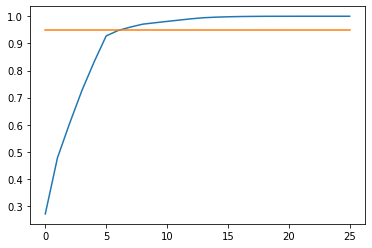

In [ ]:
# f_count of 26
f_count = len(cols)
plt.plot(np.arange(0, f_count), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(0, f_count), [0.95]*f_count)
plt.show()

It appears that a critical explained variance ratio threshold  of 95% is reached after 6 features. Let's use that for our `n_components` value.

In [ ]:
pca = PCA(n_components=6)

pca_x_train = pca.fit_transform(X_train)
pca_x_test = pca.transform(X_test)

We'll also want to combine out PCA and resample methods together at a later point so let's create those datasets here as well. 

In [ ]:
sm = SMOTE(random_state = 0)
pca_x_train_res, y_train_res = sm.fit_sample(pca_x_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(pca_x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



After OverSampling, the shape of train_X: (623626, 6)
After OverSampling, the shape of train_y: (623626,) 

After OverSampling, counts of label '1': 311813
After OverSampling, counts of label '0': 311813


## Random Forest classifier

In this next section, we'll develop a Random Forest classifier using the newly created PCA dataset and measure the resulting model performance.

In [ ]:
RFModel = Pipeline([
    ('classification', RandomForestClassifier(random_state = 0))
])

In [ ]:
clf = RFModel.fit(pca_x_train, y_train)

In [ ]:
RFModel.score(pca_x_test, y_test)

0.983012452175229

In [ ]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, RFModel.predict(pca_x_test)).ravel()
print('True Negative: ' + str(tn))
print('False Positive: ' + str(fp))
print('False Negative: ' + str(fn))
print('True Positive: ' + str(tp))


True Negative: 207857
False Positive: 1
False Negative: 3591
True Positive: 0


In [ ]:
print(classification_report(y_test, RFModel.predict(pca_x_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    207858
           1       0.00      0.00      0.00      3591

    accuracy                           0.98    211449
   macro avg       0.49      0.50      0.50    211449
weighted avg       0.97      0.98      0.97    211449



Our model has essentially not improved at all. This is upsetting! 

Let's try the resampling technique.

## Random Forest, resample label

Next, let's repeat the Random Forest Classifier, but this time using the PCA resampled data. We hope that will help correct for the rarity of label=1 observations in our dataset.

In [ ]:
clf_res = RFModel.fit(pca_x_train_res, y_train_res)

In [ ]:
RFModel.score(pca_x_test, y_test)

0.9575027548013942

In [ ]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, RFModel.predict(pca_x_test)).ravel()
print('True Negative: ' + str(tn))
print('False Positive: ' + str(fp))
print('False Negative: ' + str(fn))
print('True Positive: ' + str(tp))


True Negative: 202272
False Positive: 5586
False Negative: 3400
True Positive: 191


In [ ]:
print(classification_report(y_test, RFModel.predict(pca_x_test)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    207858
           1       0.03      0.05      0.04      3591

    accuracy                           0.96    211449
   macro avg       0.51      0.51      0.51    211449
weighted avg       0.97      0.96      0.96    211449



Finally some results! Really what we were hoping for was some true positive values. It came at the expense of our accuracy score, which is now at 96%, but we think that's ok. It's important to be able to predict some restaurant closures, and we can easily imagine use cases where policy makers may be willing to accept false positives. 

For example, if this model were being used to allocate small business relief funding and some of those funds were directed to businesses that were predicted to close based on their demonstrated needs, allocating funding to them might not be such a bad thing, even if they wouldn't have closed. 

## GridSearchCV with RandomForestClassifier

Based on the results of the two Random Forest classifiers in the previous section, the best data preparation methods appear to be PCA reduction with 6 components and a resampling of the label data using SMOTE. So we'll use those datasets in this next section where we use GridSearch to tune the RF hyperparameters. 

In [ ]:
param_grid = {
    "n_estimators": [5, 10, 15, 20, 30, 50, 100],
    "max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

param_grid

{'max_depth': [2, 5, 7, 9, 13, 21, 33, 51],
 'n_estimators': [5, 10, 15, 20, 30, 50, 100]}

In [ ]:
rf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid = GridSearchCV(rf, param_grid, cv = 3, verbose = 2)

In [ ]:
grid.fit(pca_x_train_res, y_train_res)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] max_depth=2, n_estimators=5 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... max_depth=2, n_estimators=5, total=   2.3s
[CV] max_depth=2, n_estimators=5 .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ...................... max_depth=2, n_estimators=5, total=   1.2s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   1.2s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   1.7s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   1.7s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   1.6s
[CV] max_depth=2, n_estimators=15 ....................................
[CV] ..................... max_depth=2, n_estimators=15, total=   2.3s
[CV] max_depth=2, n_estimators=15 ....................................
[CV] ..................... max_depth=2, n_estimators=15, total=   2.3s
[CV] max_depth=2, n_estimators=15 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed: 47.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=0,
                                     

In [ ]:
# The best hyper parameters
grid.best_params_

{'max_depth': 51, 'n_estimators': 100}

In [ ]:
# Evaluate the best random forest model
best_RF = grid.best_estimator_

best_RF.score(pca_x_test, y_test)

0.9574932962558348

In [ ]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, best_RF.predict(pca_x_test)).ravel()
print('True Negative: ' + str(tn))
print('False Positive: ' + str(fp))
print('False Negative: ' + str(fn))
print('True Positive: ' + str(tp))


True Negative: 202271
False Positive: 5587
False Negative: 3401
True Positive: 190


In [ ]:
print(classification_report(y_test, best_RF.predict(pca_x_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    207858
           1       0.07      0.00      0.00      3591

    accuracy                           0.98    211449
   macro avg       0.53      0.50      0.50    211449
weighted avg       0.97      0.98      0.97    211449



Using GridSearch and hyperparameter tuning, we were able to achieve a final result of 98% accuracy and 190 true positive predictions. This is an increase on accuracy from the second random classifier and about the same number of true positive predictions. 

# Conclusion

Well, we didn't build out the highly useful model we initially set out to. While our model has a very high accuracy, this is largely due to the nature of the data. The underrepresentation of closed restaurants was identified as a problem from the beginning, and it turned out to be a pernicious one. We have developed a model that correctly predicts *some* restaurant closures but misses many others. 

We continue to be interested and vexed by this important pattern and look forward to feedback on improving our modeling process. 